### Bo torch with points
This is a tutorial of Bayesian optimisation, where the objective funtion is not analytic function. Objective function are a set of points. 

In [235]:
import torch
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound,  qMaxValueEntropy
from botorch.optim import optimize_acqf

# Example training data points
train_x = torch.tensor([[0.1], [0.4], [0.7], [1.0], [1.5]])
train_y = torch.tensor([[1.0], [2.0], [1.5], [1.2], [0.5]])

# Example set of objective function points
objective_points = torch.tensor([[0.2], [0.5], [0.8], [1.1], [1.6], [1.8], [2.0]])
objective_values = torch.tensor([[1.5], [2.1], [1.4], [1.0], [0.7], [0.3], [0.1]])


In [236]:
# Normalize the training data
train_x_normalized = (train_x - train_x.min()) / (train_x.max() - train_x.min())
train_y_normalized = (train_y - train_y.min()) / (train_y.max() - train_y.min())

# Define and fit GP model
gp_model = SingleTaskGP(train_x_normalized, train_y_normalized)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)


C:\Users\shail\AppData\Local\Temp\ipykernel_32528\4009227148.py:6: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp_model = SingleTaskGP(train_x_normalized, train_y_normalized)
c:\Users\shail\anaconda3\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4933]), std = tensor([0.3730])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [237]:
# Use Expected Improvement as the acquisition function
best_f = train_y_normalized.max().item()
acq_func = ExpectedImprovement(gp_model, best_f=best_f)
# acq_func = UpperConfidenceBound(gp_model, beta=2)
# mes_acq_func = qMaxValueEntropy(gp_model, candidate_set=objective_points_normalized)


In [238]:
# Normalize the objective points
objective_points_normalized = (objective_points - train_x.min()) / (train_x.max() - train_x.min())

# Optimize the acquisition function over the normalized objective points
candidate, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=torch.tensor([[0.0], [1.0]]),
    q=1,
    num_restarts=5,
    raw_samples=20,
    options={"sequential": True},  # Ensure sequential optimization over discrete points
)

new_x_normalized = candidate
new_x = new_x_normalized * (train_x.max() - train_x.min()) + train_x.min()  # Unnormalize

# Find the closest value from the objective points
distances = torch.abs(objective_points - new_x)
closest_idx = torch.argmin(distances)
new_x = objective_points[closest_idx].view(-1, 1)
new_y = objective_values[closest_idx].view(-1, 1)


In [239]:
# Update the dataset
train_x = torch.cat([train_x, new_x])
train_y = torch.cat([train_y, new_y])


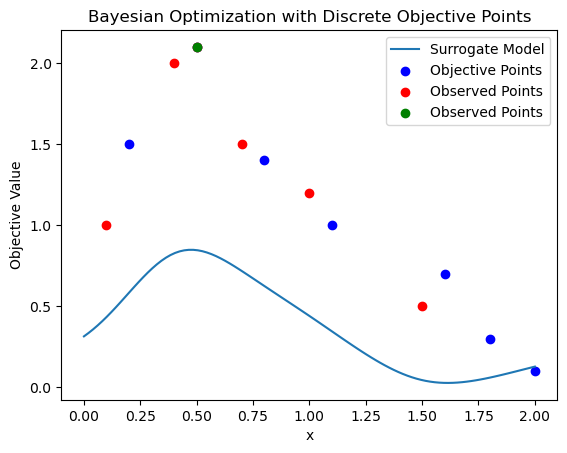

In [240]:
# Plot the surrogate model and the points
x = torch.linspace(0, 2, 100).unsqueeze(-1)
x_normalized = (x - train_x.min()) / (train_x.max() - train_x.min())
y = gp_model.posterior(x_normalized).mean.detach()
plt.plot(x.numpy(), y.numpy(), label='Surrogate Model')
plt.scatter(objective_points.numpy(), objective_values.numpy(), color='blue', label='Objective Points')
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label='Observed Points')
plt.scatter(new_x, new_y, color='green', label='Observed Points')
plt.xlabel('x')
plt.ylabel('Objective Value')
plt.title('Bayesian Optimization with Discrete Objective Points')
plt.legend()
plt.show()


This is a iteration loop generating a set of points

In [241]:
import torch
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
import numpy as np

# Generate more points for the training data and objective function points
num_train_points = 10
num_objective_points = 50
noise_std = 0.1  # Standard deviation of the noise

# Generate points on a circle for objective points
angles = torch.linspace(0, 2 * np.pi, num_objective_points)
circle_x = torch.cos(angles).unsqueeze(-1)
circle_y = torch.sin(angles).unsqueeze(-1)

# Use these points as both the training data and the objective function points
objective_points = torch.cat([circle_x, circle_y], dim=1)
objective_values = torch.sin(angles).unsqueeze(-1)  # Example values on the circle

# Initial training data (a subset of the objective points)
train_x = objective_points[::5][:num_train_points]
train_y = objective_values[::5][:num_train_points]

# Add noise to the initial training data
train_y_noisy = train_y + noise_std * torch.randn(train_y.size())

# Number of iterations
num_iterations = 10

# List to store new points
new_points_x = []
new_points_y = []

for i in range(num_iterations):
    # Normalize the training data
    train_x_normalized = (train_x - train_x.min(dim=0, keepdim=True)[0]) / (train_x.max(dim=0, keepdim=True)[0] - train_x.min(dim=0, keepdim=True)[0])
    train_y_normalized = (train_y_noisy - train_y_noisy.min()) / (train_y_noisy.max() - train_y_noisy.min())

    # Define and fit GP model
    gp_model = SingleTaskGP(train_x_normalized, train_y_normalized)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)

    # Use Upper Confidence Bound (UCB) as the acquisition function for exploration
    acq_func = UpperConfidenceBound(gp_model, beta=2.0)

    # Normalize the objective points
    objective_points_normalized = (objective_points - train_x.min(dim=0, keepdim=True)[0]) / (train_x.max(dim=0, keepdim=True)[0] - train_x.min(dim=0, keepdim=True)[0])

    # Optimize the acquisition function over the normalized objective points
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0, 0.0], [1.0, 1.0]]),
        q=1,
        num_restarts=5,
        raw_samples=20,
        options={"sequential": True},  # Ensure sequential optimization over discrete points
    )

    new_x_normalized = candidate
    new_x = new_x_normalized * (train_x.max(dim=0, keepdim=True)[0] - train_x.min(dim=0, keepdim=True)[0]) + train_x.min(dim=0, keepdim=True)[0]  # Unnormalize

    # Find the closest value from the objective points
    distances = torch.norm(objective_points - new_x, dim=1)
    closest_idx = torch.argmin(distances)
    new_x = objective_points[closest_idx].view(1, -1)
    new_y = objective_values[closest_idx].view(1, -1)

    # Add noise to the new point
    new_y_noisy = new_y + noise_std * torch.randn(new_y.size())

    # Check if the new point is already in the training set
    if not (train_x == new_x).all(dim=1).any():
        new_points_x.append(new_x)
        new_points_y.append(new_y_noisy)
        train_x = torch.cat([train_x, new_x])
        train_y_noisy = torch.cat([train_y_noisy, new_y_noisy])

# Plot the results
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1, color='lightblue', fill=False)
ax.add_artist(circle)

ax.scatter(objective_points[:, 0].numpy(), objective_points[:, 1].numpy(), color='blue', label='Objective Points')
ax.scatter(train_x[:, 0].numpy(), train_x[:, 1].numpy(), color='red', label='Observed Points')

# Plot the surrogate model (only works well in 1D, but for illustration)
x = torch.linspace(-1.5, 1.5, 100)
y = torch.linspace(-1.5, 1.5, 100)
X, Y = torch.meshgrid(x, y)
Z = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)
Z_normalized = (Z - train_x.min(dim=0, keepdim=True)[0]) / (train_x.max(dim=0, keepdim=True)[0] - train_x.min(dim=0, keepdim=True)[0])
posterior = gp_model.posterior(Z_normalized)
Z_values = posterior.mean.detach().numpy().reshape(100, 100)
ax.contourf(X.numpy(), Y.numpy(), Z_values, levels=20, cmap='viridis', alpha=0.6)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Optimization with Increased Data and Noisy Observations')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


C:\Users\shail\AppData\Local\Temp\ipykernel_32528\4212675555.py:31: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp_model = SingleTaskGP(train_x_normalized, train_y_normalized)
c:\Users\shail\anaconda3\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4933]), std = tensor([0.3730])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\shail\AppData\Local\Temp\ipykernel_32528\4212675555.py:31: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/d

c:\Users\shail\anaconda3\Lib\site-packages\numpy\ma\core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,


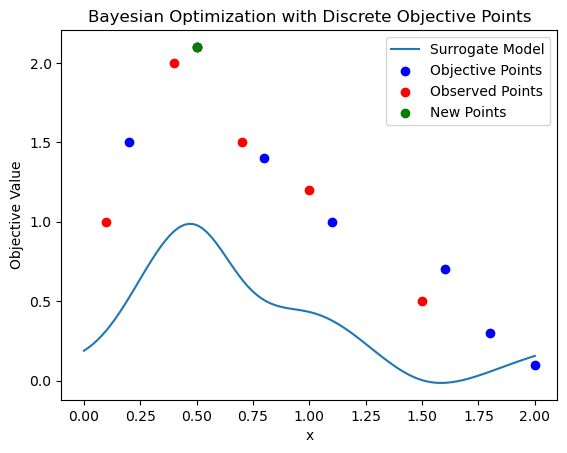

In [242]:
# Plot the surrogate model and the points
x = torch.linspace(0, 2, 100).unsqueeze(-1)
x_normalized = (x - train_x.min()) / (train_x.max() - train_x.min())
y = gp_model.posterior(x_normalized).mean.detach()
plt.plot(x.numpy(), y.numpy(), label='Surrogate Model')
plt.scatter(objective_points.numpy(), objective_values.numpy(), color='blue', label='Objective Points')
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label='Observed Points')
plt.scatter(new_points_x, new_points_y, color='green', label='New Points')
plt.xlabel('x')
plt.ylabel('Objective Value')
plt.title('Bayesian Optimization with Discrete Objective Points')
plt.legend()
plt.show()